In [1]:
%pip install psycopg2-binary
%pip install pandas
%pip install numpy
%pip install scipy
%pip install ipywidgets
%pip install requests

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


----
# Metadata Wide Association Study

The BioSample database is 


When performing MWAS, we want a specified set of runs. This can be an arbitrary set of runs supplied by the end user or more commonly, a query of the Serratus database looking for a specific virus or virus family. 

In [1]:
import psycopg2
import pandas as pd
import numpy as np
from scipy import stats
import ipywidgets as widgets
import requests

# database connection details
host = "serratus-aurora-20210406.cluster-ro-ccz9y6yshbls.us-east-1.rds.amazonaws.com"
database = "summary"
user = "public_reader"
password = "serratus"

# ensure connection is valid then close
try:
    conn = psycopg2.connect(host=host, database=database, user=user, password=password)
    conn.close()
    print("Successfully connected to Serratus 🗻")
except:
    print("Error conecting to database.")



Successfully connected to Serratus 🗻


In [2]:
# MAKE A NICE INTERFACE HERE FOR USERS TO CHOSSE DATA TO RUN MWAS ON
# https://stackoverflow.com/questions/32714783/ipython-run-all-cells-below-from-a-widget
# create a text box asking users to enter a list of SRA accessions
text = widgets.Text(
    value='',
    placeholder='Enter SRA accessions',
    description='SRA:',
    disabled=False
)
display(text)
# add OR in the middle of the two SRA accessions
or_text = widgets.Text(
    value='',
    placeholder='OR',
    description='',
    disabled=False
)
display(or_text)
# add a drop down box for users to query by viral family
dropdown = widgets.Dropdown(
    options=['Coronaviridae', 'Flaviviridae', 'Orthomyxoviridae', 'Paramyxoviridae', 'Picornaviridae', 'Poxviridae', 'Rhabdoviridae', 'Togaviridae'],
    value='Coronaviridae',
    description='Virus:',
    disabled=False,
)
display(dropdown)

# add a button to submit the list of SRA accessions
button = widgets.Button(description="Submit")
display(button)

# DATA INPUT NOT WORKING YET TODO

Text(value='', description='SRA:', placeholder='Enter SRA accessions')

Text(value='', placeholder='OR')

Dropdown(description='Virus:', options=('Coronaviridae', 'Flaviviridae', 'Orthomyxoviridae', 'Paramyxoviridae'…

Button(description='Submit', style=ButtonStyle())

In [5]:
import warnings

warnings.filterwarnings('ignore') # FIX THIS LATERE TO NOT IGNORE WARNINGS

'''
rfamily database contains the number of reads of the virus for each run and the corresponding family_group

srarun database contains the number of spots for the run and the corresponding bio_sample, sample, bio_project, scientific_name

    https://stackoverflow.com/questions/71082494/getting-a-warning-when-using-a-pyodbc-connection-object-with-pandas#comment127279177_71083448
'''
q1 = """
    SELECT run_id, family_group, coverage_bins, percent_identity, n_reads
    FROM rfamily
    WHERE run_id IN ('SRR13579218', 'SRR13579219', 'SRR13579220', 'SRR13579221', 'SRR13579222', 'SRR13579223', 'SRR13579224', 'SRR13579225', 'SRR13579226','SRR5041706', 'SRR5041707', 'SRR5041708', 'SRR5041709', 'SRR5041710', 'SRR5041711', 'SRR5041712', 'SRR5041713','SRR13099696', 'SRR13099697', 'SRR13099698', 'SRR13099699', 'SRR13099700', 'SRR13099701', 'SRR13099714', 'SRR13099715', 'SRR13099716', 'SRR13099717')
    AND family_group = 'Totiviridae-10';
"""

q2 = """
    SELECT run, bio_sample, sample, bio_project, scientific_name, spots
    FROM srarun
    WHERE run IN ('SRR13579218', 'SRR13579219', 'SRR13579220', 'SRR13579221', 'SRR13579222', 'SRR13579223', 'SRR13579224', 'SRR13579225', 'SRR13579226','SRR5041706', 'SRR5041707', 'SRR5041708', 'SRR5041709', 'SRR5041710', 'SRR5041711', 'SRR5041712', 'SRR5041713','SRR13099696', 'SRR13099697', 'SRR13099698', 'SRR13099699', 'SRR13099700', 'SRR13099701', 'SRR13099714', 'SRR13099715', 'SRR13099716', 'SRR13099717')
    """

# # queries to work for rhabdoviridae-4
# q1 = """
# SELECT run_id, family_group, coverage_bins, percent_identity, n_reads
# FROM rfamily
# WHERE family_group='Rhabdoviridae-4'
# """
# q2 = """
# SELECT run, bio_sample, sample, bio_project, scientific_name, spots
# FROM srarun
# WHERE run in ('SRR9319966', 'SRR8648011', 'ERR1044906', 'ERR1198117', 'SRR13494481', 'SRR10377086', 'ERR1543942', 'SRR10323723', 'DRR086713', 'ERR2835397', 'ERR4172297', 'ERR4920350', 'ERR6001931', 'ERR9465223', 'SRR10030090', 'SRR10130817', 'SRR10130820', 'SRR12030757', 'SRR12887796', 'SRR13014040', 'SRR13557531', 'SRR14509875', 'SRR15744718', 'SRR16379938', 'SRR16379939', 'SRR16379945', 'SRR16379954', 'SRR16379960', 'SRR16379961', 'SRR16379962', 'SRR16379963', 'SRR16379964', 'SRR16379965', 'SRR16970136', 'SRR1752288', 'SRR4295161', 'SRR13081922', 'SRR5580766', 'SRR14689415', 'SRR6030362', 'SRR6395541', 'SRR6214974', 'SRR6214979', 'SRR6214980', 'SRR6214983', 'SRR6214991', 'SRR6395543', 'SRR6395544', 'SRR8149078', 'SRR6854578', 'SRR15860029', 'SRR16379936', 'SRR16379952', 'SRR16379967', 'SRR16379941', 'SRR16379943', 'SRR16379946', 'SRR16379940', 'SRR16379942', 'SRR16379937', 'SRR16379947', 'SRR16379958', 'SRR3193035', 'SRR1748635', 'SRR1752290', 'SRR17771310', 'SRR22537549', 'SRR3086499', 'SRR3401917', 'SRR3401909', 'SRR6185437', 'SRR7507870', 'SRR7507875', 'DRR022329', 'ERR4920231', 'ERR6002040', 'SRR12042642', 'SRR12114811', 'SRR6214990', 'SRR6214976', 'SRR6214971', 'SRR6214985', 'SRR6214982', 'SRR6214986', 'SRR6395542', 'SRR7221698', 'ERR1543953', 'ERR7439116', 'SRR10394515', 'SRR11088378')
# """


# connect to database
with psycopg2.connect(host=host, database=database, user=user, password=password) as conn:
    # run the queries and store the results in dataframes
    rfam_df = pd.read_sql_query(q1, conn)
    srarun_df = pd.read_sql_query(q2, conn)

# select the unique bio_projects from the srarun_df
bio_projects = set(srarun_df['bio_project'].unique())

In [6]:
# requery the srarun database to fetch all runs from the unique bio_projects

# query the srarun databse to fetch all runs from the unique bio_projects
q3 = """
    SELECT run, bio_sample, sample, bio_project, scientific_name, spots
    FROM srarun
    where bio_project in 
    """
# add the bio_projects to the query
q3 += str(tuple(bio_projects))

with psycopg2.connect(host=host, database=database, user=user, password=password) as conn:
    # run the query and store the results in a dataframe
    srarun_bio_projects = pd.read_sql_query(q3, conn)

# use the set of all runs from the bioprojects to requery the rfam database
all_runs = set(srarun_bio_projects['run'])

# q4 = """
#     SELECT run_id, family_group, coverage_bins, percent_identity, n_reads
#     FROM rfamily
#     WHERE run_id in 
#     """
# # add the runs to the query
# q4 += str(tuple(all_runs))

# with psycopg2.connect(host=host, database=database, user=user, password=password) as conn:
#     # run the query and store the results in a dataframe
#     rfam_all_runs = pd.read_sql_query(q4, conn) # NOT USED

# NOT IMPLEMENTED YET
    

In [7]:
# merge the dataframes on the run_id column (run in srarun_df)
mwas_df = pd.merge(rfam_df, srarun_df, left_on='run_id', right_on='run')
# ensure the sizes of the dataframes are consistent
assert len(rfam_df) == len(mwas_df) == len(srarun_df)

# drop the run column
mwas_df = mwas_df.drop(columns=['run'])

# replace 0 with 1000000 for the spots column
mwas_df['spots'] = mwas_df['spots'].replace(0, 1000000)

mwas_df.head()

,run_id,family_group,coverage_bins,percent_identity,n_reads,bio_sample,sample,bio_project,scientific_name,spots
0,SRR13099696,Totiviridae-10,MMMOMMMMMMMOMMOMMOMOMOMOO,99,58148,SAMN16846142,SRS7750070,PRJNA679749,Saccharomyces cerevisiae,22477855
1,SRR13099697,Totiviridae-10,wwaawawaaaaaoaawaaaaaaaaa,99,503,SAMN16846141,SRS7750069,PRJNA679749,Saccharomyces cerevisiae,26506334
2,SRR13099698,Totiviridae-10,oooaomaoooooooaomoommommo,99,1302,SAMN16846140,SRS7750068,PRJNA679749,Saccharomyces cerevisiae,28431158
3,SRR13099700,Totiviridae-10,oooaoaooaaooooaoaaooooooa,99,930,SAMN16846138,SRS7750066,PRJNA679749,Saccharomyces cerevisiae,22866795
4,SRR13099701,Totiviridae-10,mmUmmmmUmmmmUUmmUmmmmmmmm,99,2712,SAMN16846137,SRS7750064,PRJNA679749,Saccharomyces cerevisiae,25239410


In [8]:
# ensure that every run has a bio_sample and bio_project
# - if a run has no biosample, then there is no metadata to run MWAS on0

if mwas_df['bio_sample'].isnull().sum() != 0:
    print("The following runs will be dropped as they have no associated bio_sample:")
    print(mwas_df[mwas_df['bio_sample'].isnull()]['run_id'])
    mwas_df = mwas_df.dropna(subset=['bio_sample'])
else:
    # all runs should have associated bio_samples and bio_projects
    assert mwas_df['bio_sample'].isnull().sum() == 0, "Error: some runs are missing bio_sample ids"
    assert mwas_df['bio_project'].isnull().sum() == 0, "Error: some runs are missing bio_project ids"


# calculate the mean percent identity for each bio_project and add it to the dataframe
mwas_df['mean_percent_identity'] = mwas_df.groupby('bio_project')['percent_identity'].transform('mean')
mwas_df.head()

,run_id,family_group,coverage_bins,percent_identity,n_reads,bio_sample,sample,bio_project,scientific_name,spots,mean_percent_identity
0,SRR13099696,Totiviridae-10,MMMOMMMMMMMOMMOMMOMOMOMOO,99,58148,SAMN16846142,SRS7750070,PRJNA679749,Saccharomyces cerevisiae,22477855,99.0
1,SRR13099697,Totiviridae-10,wwaawawaaaaaoaawaaaaaaaaa,99,503,SAMN16846141,SRS7750069,PRJNA679749,Saccharomyces cerevisiae,26506334,99.0
2,SRR13099698,Totiviridae-10,oooaomaoooooooaomoommommo,99,1302,SAMN16846140,SRS7750068,PRJNA679749,Saccharomyces cerevisiae,28431158,99.0
3,SRR13099700,Totiviridae-10,oooaoaooaaooooaoaaooooooa,99,930,SAMN16846138,SRS7750066,PRJNA679749,Saccharomyces cerevisiae,22866795,99.0
4,SRR13099701,Totiviridae-10,mmUmmmmUmmmmUUmmUmmmmmmmm,99,2712,SAMN16846137,SRS7750064,PRJNA679749,Saccharomyces cerevisiae,25239410,99.0


In [9]:
# set up variables for API call
base_url = 'https://serratus-biosamples.s3.us-east-1.amazonaws.com/biosamples_csv/'
headers = {'Host': 'serratus-biosamples.s3.amazonaws.com'}

In [10]:
print(len(bio_projects))
counter = 0
for bioproject_id in bio_projects:
    counter += len(srarun_bio_projects[srarun_bio_projects['bio_project'] == bioproject_id]['bio_sample'].unique())

print(counter)

3
35


In [11]:
import io

# create a dataframe to store output of MWAS testing
mwas_output_cols = ['bioproject_id', 'metadata_field', 'metadata_term', 'n_true', 'n_false', 'mean_rpm_true', 'mean_rpm_false', 'sd_rpm_true', 'sd_rpm_false', 'fold_change', 'p_value', 'z_score']
mwas_output_dict = {col: [] for col in mwas_output_cols}

for bioproject_id in bio_projects:
    print("Analyzing BioProject:", bioproject_id)
    # select all biosamples that correspond to the bioproject_id
    # - subset the srarun_bio_projects by the bioproject_id and select the unique biosamples
    # - biosamples with bioproject_id subset from the srarun_df should be a subset of the biosamples from the srarun_bio_projects
    all_biosamples = srarun_bio_projects[srarun_bio_projects['bio_project'] == bioproject_id]['bio_sample'].unique()
    assert len(srarun_df[srarun_df['bio_project'] == bioproject_id]['bio_sample'].unique()) <= len(all_biosamples), "BioSample error"

    # don't use additional biosamples since merging is wrong
    all_biosamples = srarun_df[srarun_df['bio_project'] == bioproject_id]['bio_sample'].unique()

    # print(bioproject_id)

    biosample_df = pd.DataFrame()
    first_biosample = True
    print("Fetching BioSamples...")
    # make a request to the API for each biosample
    for biosample_id in all_biosamples:
        # creates the whole csv for the BioProject
        # make a request to the API for the biosample
        url = base_url + biosample_id + '.csv'
        response = requests.get(url, headers=headers)
        # print error message and skip if the request fails
        if response.status_code != 200:
            print(f"Error: {response.status_code} for {biosample_id}")
            continue
        result_string = response.content.decode('utf-8')
        # ASSUME THAT ALL BIOPROJECTS ARE NICE AND HAVE THE SAME COLUMNS
        # create a binary stream from the string
        result_string = io.StringIO(result_string)
        # convert the result string to a dataframe
        result_df = pd.read_csv(result_string)
        if first_biosample:
            biosample_df = result_df
            first_biosample = False
        else:
            # concat the result_df to the biosample_df
            biosample_df = pd.concat([biosample_df, result_df])
        
    # skip the bioproject if there are no biosamples available
    if len(biosample_df) == 0:
        print(f"Skipping BioProject {bioproject_id} as there are no biosamples available")
        continue
    print("Running preprocessing...")
    # store the number of biosamples for the bioproject
    num_biosamples = len(biosample_df)
    
    # remove all columns starting with GEO Sample * FIND A BETTER WAY TO DO THIS LATER
    biosample_df = biosample_df.loc[:, ~biosample_df.columns.str.startswith('GEO Sample')]

    # add the SRR accessions and read counts (n_reads) to the biosample_df
    # TODO DON"T BE STUPID AND MERGE PROPERLY
    try:
        biosample_merged = pd.merge(biosample_df, mwas_df[['sample', 'run_id', 'family_group', 'n_reads', 'spots', 'mean_percent_identity']], left_on='SRA_db', right_on='sample', how='inner')
    except:
        print("Error merging biosample_df and mwas_df")
        continue
    # biosample_merged = pd.merge(biosample_df, mwas_df[['sample', 'run_id', 'family_group', 'n_reads', 'spots', 'mean_percent_identity']], left_on='SRA_db', right_on='sample', how='left')
    
    # drop the repeated sample and BioSample_db column
    biosample_merged = biosample_merged.drop(columns=['sample'])
    biosample_merged = biosample_merged.drop(columns=['BioSample_db'])
    # calcualte the standardised RPM for viral reads (n_reads)
    biosample_merged['RPM'] = biosample_merged['n_reads'] / biosample_merged['spots'] * 1000000
    # biosample merged now contains a dataframe with metadata as well as the spots and n_reads for each run
    # - spots is the number of spots in the sequencing for the run
    # - n_reads is the number of reads of the virus for the run
    # - RPM is the standardised RPM for viral reads (n_reads)
    # want to see if there are any variables that correlate with the RPM of viral reads

    # add a spoof column to the biosample_merged dataframe that has the same values as compound=none to test column aggregation
    # biosample_merged['aggregate'] = biosample_merged.apply(lambda x: 1 if x['run_id'] in {'SRR13579221', 'SRR13579222', 'SRR13579223'} else 0, axis=1)
    # add a spoof column to the biosample_merged dataframe that tests for binary variable catching
    # biosample_merged['bin_var'] = biosample_merged.apply(lambda x: 1 if x['run_id'] in {'SRR13579218', 'SRR13579220', 'SRR13579219', 'SRR13579226'} else 0, axis=1)

    # ignore some of the columns as they are common to all biosamples and are not useful for analysis
    common_cols = {'biosample_id', 'submission_date', 'last_update', 'publication_date', 'access', 'SRA_db', 'GEO_db', 'package', 'bioproject', 'run_id', 'family_group', 'n_reads', 'spots', 'mean_percent_identity', 'organism_taxonomy_id'}
    target_cols = set(biosample_merged.columns) - common_cols

    # create a dict to store the value counts for each column
    metadata_counts = {}
    binary_cols = set() # store binary columns to ensure ttests are not run twice
    # choose the columns to analyze and store the column and the corresponding value counts in the metadata_counts dict
    for target_col in target_cols:
        # generate the dictionary of value counts for the target column
        value_counts = biosample_merged[target_col].value_counts().to_dict()
        if len(value_counts) <= 1 or len(value_counts) == num_biosamples:
            # target col either has only one value or has a unique value for each biosample
            # print(f"Skipping {target_col} as it is constant")
            continue
        else:
            # at least one of the values is repeated
            if len(value_counts) == 2:
                binary_cols.add(target_col) 
            # print(f"Analyzing {target_col}")
            metadata_counts[target_col] = value_counts


    # create a set to store sets of existing runs to check for any overlap between columns
    existing_runs = []

    target_col_runs = {}
    # change the dictionary to show the run_ids for each value
    for target_col, value_counts in metadata_counts.items():
        for target_term, count in value_counts.items():
            # exclude any terms that only appear once
            if count > 1:
                # get the run_ids for the target term
                target_run_ids = set(biosample_merged[biosample_merged[target_col] == target_term]['run_id'])
                # check if the target_run_ids are already in the existing_runs set
                if target_run_ids in existing_runs:
                    # target_run_ids is already in the set so aggregate the column with the existing column
                    # update the name of the target_col_runs dict to include the additional target_term
                    target_col_name = target_col + '\t' + str(target_term)
                    # find the existing key in the target_col_runs dict
                    existing_key = list(target_col_runs.keys())[list(target_col_runs.values()).index(target_run_ids)]
                    target_col_name = target_col_name + '\r' + existing_key
                    # update the existing key to the new key by separating with '\r'
                    target_col_runs[target_col_name] = target_col_runs.pop(existing_key)
                else:
                    # target_run_ids is not in the set
                    # add the target_run_ids to the existing_runs set
                    existing_runs.append(target_run_ids)
                    # add the target_run_ids to the target_col_runs dict
                    target_col_runs[target_col + '\t' + str(target_term)] = target_run_ids # ASSUMES THAT '\t' IS NOT IN THE TARGET TERM OR TARGET COL

            if target_col in binary_cols:
                pass
                # target_col is a binary variable so don't add the opposite term to the target_col_runs dict
                # will not exclude binary values with only 1 run as the value_counts dict is sorted by count
                # DOES NOT WORK WITH AGGREGATED COLUMNS AND BINARY COLUMNS 
                # break


    # print(target_col_runs)
    print("Running ttests...")
    # target_col_runs now contains a dict of the columns (aggregated if necessary) and the corresponding run_ids
    # for each key in the dict, extract the RPM values for the runs and run a ttest
    # add the results of the ttest to the mwas_output dataframe
    for target_col, target_run_ids in target_col_runs.items():
        num_true = len(target_run_ids)
        num_false = num_biosamples - num_true
        # get the RPM values for the target_run_ids and the remaining run_ids
        target_rpm = biosample_merged[biosample_merged['run_id'].isin(target_run_ids)]['RPM']
        remaining_rpm = biosample_merged[~biosample_merged['run_id'].isin(target_run_ids)]['RPM']
        mean_rpm_true = target_rpm.mean()
        mean_rpm_false = remaining_rpm.mean()
        sd_rpm_true = target_rpm.std()
        sd_rpm_false = remaining_rpm.std()
        fold_change = mean_rpm_true / mean_rpm_false if mean_rpm_true > mean_rpm_false else mean_rpm_false / mean_rpm_true
        # run a ttest
        _, p_value = stats.ttest_ind(target_rpm, remaining_rpm, equal_var=True) # CHECK THIS SHIT
        # add a new row to the mwas_output dataframe
        # split the target_col into metadata_field and metadata_term
        metadata_tmp = target_col.split('\r')
        metadata_field = '\t'.join(pair.split('\t')[0] for pair in metadata_tmp)
        metadata_term = '\t'.join(pair.split('\t')[1] for pair in metadata_tmp)
        z_score = (mean_rpm_true - mean_rpm_false) / sd_rpm_false

        # add the data to the dictionary 
        mwas_output_dict['bioproject_id'].append(bioproject_id)
        mwas_output_dict['metadata_field'].append(metadata_field)
        mwas_output_dict['metadata_term'].append(metadata_term)
        mwas_output_dict['n_true'].append(num_true)
        mwas_output_dict['n_false'].append(num_false)
        mwas_output_dict['mean_rpm_true'].append(mean_rpm_true)
        mwas_output_dict['mean_rpm_false'].append(mean_rpm_false)
        mwas_output_dict['sd_rpm_true'].append(sd_rpm_true)
        mwas_output_dict['sd_rpm_false'].append(sd_rpm_false)
        mwas_output_dict['fold_change'].append(fold_change)
        mwas_output_dict['p_value'].append(p_value)
        mwas_output_dict['z_score'].append(z_score)


    print("Done\n")
    # break
    


mwas_output = pd.DataFrame.from_dict(mwas_output_dict)
# sort the dataframe by p_value
mwas_output = mwas_output.sort_values(by=['p_value'])
mwas_output


Analyzing BioProject: PRJNA697950
Fetching BioSamples...
Running preprocessing...
Running ttests...
Done

Analyzing BioProject: PRJNA354419
Fetching BioSamples...
Running preprocessing...
Running ttests...
Done

Analyzing BioProject: PRJNA679749
Fetching BioSamples...
Running preprocessing...
Running ttests...
Done



,bioproject_id,metadata_field,metadata_term,n_true,n_false,mean_rpm_true,mean_rpm_false,sd_rpm_true,sd_rpm_false,fold_change,p_value,z_score
6,PRJNA354419,strain\torganism_taxonomy_name,"BY4741, upf1::KanMX4\tSaccharomyces cerevisiae",4,4,2642.746834,11.099790,343.724665,1.578220,238.089802,0.000005,1667.477671
4,PRJNA697950,compound,CdSe/ZnS QD,3,6,1006.481187,81.037758,383.620190,48.718988,12.419904,0.000421,18.995539
11,PRJNA679749,isolation_source\tcollection_date,"Chemostat anaerobic, 20 g/L glucose, SM urea m...",2,8,1316.348235,33.561135,1796.833859,31.396674,39.222400,0.034097,40.857420
1,PRJNA697950,when,2021-01-30T00:50:21.227,2,7,887.197138,247.325119,457.117922,442.197190,3.587170,0.115562,1.447029
7,PRJNA354419,strain\torganism_taxonomy_name,"JRY9177, derived from IFO 1815T, MATa hoD::Kan...",2,6,9.780551,1765.970899,0.692608,1384.143956,180.559450,0.139603,-1.268792
8,PRJNA354419,strain\torganism_taxonomy_name,"JRY9189, derived from CBS 7001, MATa hoD::NatM...",2,6,12.419029,1765.091406,0.176247,1385.481073,142.127968,0.140579,-1.265028
5,PRJNA697950,compound,InP/ZnS,3,6,54.868774,556.843964,23.801112,550.272026,10.148650,0.170871,-0.912231
3,PRJNA697950,compound,none,3,6,107.206742,530.674980,57.557879,575.119320,4.950015,0.258558,-0.736314
2,PRJNA697950,when,2021-01-30T00:50:21.197,2,7,41.757708,488.879241,10.078967,533.542104,11.707521,0.296133,-0.838025
10,PRJNA679749,collection_date,2018-08-28,4,6,19.998737,470.198433,9.892004,1037.463789,23.511407,0.419863,-0.433943


----
# Rhabdoviridae-4

In [108]:
bioproject_id = 'PRJNA772049'
all_biosamples = srarun_bio_projects[srarun_bio_projects['bio_project'] == bioproject_id]['bio_sample'].unique()
biosample_df = pd.DataFrame()
first_biosample = True
print("Fetching BioSamples...")
# make a request to the API for each biosample
for biosample_id in all_biosamples:
    # creates the whole csv for the BioProject
    # make a request to the API for the biosample
    url = base_url + biosample_id + '.csv'
    response = requests.get(url, headers=headers)
    # print error message and skip if the request fails
    if response.status_code != 200:
        print(f"Error: {response.status_code} for {biosample_id}")
        continue
    result_string = response.content.decode('utf-8')
    # ASSUME THAT ALL BIOPROJECTS ARE NICE AND HAVE THE SAME COLUMNS
    # create a binary stream from the string
    result_string = io.StringIO(result_string)
    # convert the result string to a dataframe
    result_df = pd.read_csv(result_string)
    if first_biosample:
        biosample_df = result_df
        first_biosample = False
    else:
        # concat the result_df to the biosample_df
        biosample_df = pd.concat([biosample_df, result_df])

biosample_df.head()

Fetching BioSamples...


,biosample_id,submission_date,last_update,publication_date,access,BioSample_db,Sample name_db,SRA_db,title,organism_taxonomy_id,...,tissue,age,biomaterial_provider,dev_stage,sex,temp,bioproject,status,when,paragraph
0,SAMN22357952,2021-10-18T02:45:03.700,2022-11-20T00:50:10.533,2022-11-20T00:50:10.533,public,SAMN22357952,13 FJ1 ST,SRS10610552,Invertebrate sample from Thenus australiensis,762109,...,Stomach,Juvenile,"IMAS, Tasmania",Juvenile,female,27°C,772049,live,2022-11-20T00:50:10.533,NaN
0,SAMN22357951,2021-10-18T02:45:03.680,2022-11-20T00:50:10.517,2022-11-20T00:50:10.517,public,SAMN22357951,12 MJ2 ST,SRS10610551,Invertebrate sample from Thenus australiensis,762109,...,Stomach,Juvenile,"IMAS, Tasmania",Juvenile,male,27°C,772049,live,2022-11-20T00:50:10.517,NaN
0,SAMN22357942,2021-10-18T02:45:03.523,2022-11-20T00:50:15.977,2022-11-20T00:50:15.977,public,SAMN22357942,2 MJ2 TS,SRS10610550,Invertebrate sample from Thenus australiensis,762109,...,Testis,Juvenile,"IMAS, Tasmania",Juvenile,male,27°C,772049,live,2022-11-20T00:50:15.977,NaN
0,SAMN22357941,2021-10-18T02:45:03.503,2022-11-20T00:50:15.950,2022-11-20T00:50:15.950,public,SAMN22357941,1 MJ1 TS,SRS10610549,Invertebrate sample from Thenus australiensis,762109,...,Testis,Juvenile,"IMAS, Tasmania",Juvenile,male,27°C,772049,live,2022-11-20T00:50:15.950,postmoult
0,SAMN22357950,2021-10-18T02:45:03.667,2022-11-20T00:50:10.460,2022-11-20T00:50:10.460,public,SAMN22357950,11 MJ1 ST,SRS10610548,Invertebrate sample from Thenus australiensis,762109,...,Stomach,Juvenile,"IMAS, Tasmania",Juvenile,male,27°C,772049,live,2022-11-20T00:50:10.460,postmoult


In [109]:
biosample_merged = pd.merge(biosample_df, mwas_df[['sample', 'run_id', 'family_group', 'n_reads', 'spots', 'mean_percent_identity']], left_on='SRA_db', right_on='sample', how='inner')
biosample_merged = biosample_merged.drop(columns=['sample'])
biosample_merged = biosample_merged.drop(columns=['BioSample_db'])
# calcualte the standardised RPM for viral reads (n_reads)
biosample_merged['RPM'] = biosample_merged['n_reads'] / biosample_merged['spots'] * 1000000

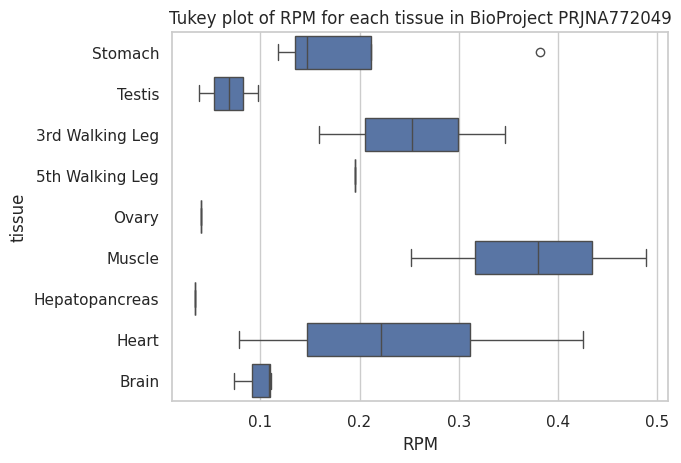

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot a tukey plot of mean RPM for each tissue
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y="tissue", x="RPM", data=biosample_merged)
# add a title
ax.set_title("Tukey plot of RPM for each tissue in BioProject PRJNA772049")

plt.show()
